# Image Classification on MNIST using MLP/ResNet18/LeNet-5

In [1]:
# Libraries
import torch
import torchvision
import random
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Callable

In [2]:
DEVICE = "cpu"

In [3]:
torch.backends.mps.is_available()

True

In [4]:
torch_device = torch.device("cpu")

In [5]:
# Set seeds for pytorch, numpy and random
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## Step 1: Data Installation and Preprocessing

In [6]:
# MNIST normalization values
mean = 0.1307
std = 0.3081

In [7]:
# Transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

In [8]:
# Download MNIST datasets
train_data = MNIST(root="data", train=True, transform=transform, download=True)

test_data = MNIST(root="data", train=False, transform=transform, download=True)

In [9]:
# Move data into dataloader
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

In [23]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape) 

torch.Size([4, 1, 28, 28])
torch.Size([4])


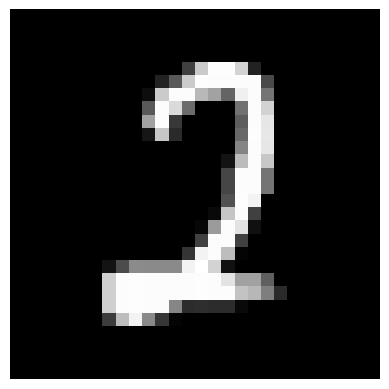

In [24]:
# Visualize an imge
img_tensor = images[0]

img_data = img_tensor.squeeze().numpy()
cmap_val = "gray" 

plt.imshow(img_data, cmap=cmap_val)
plt.axis("off")
plt.show()


## Step 2: Model Training and Implementation

### 2.1: Implementing Multi-Layer Perceptron

In [12]:
class MLP(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),               # 28*28 -> 784
            nn.Linear(784, 256),        # 784 -> 256
            nn.ReLU(),                  # Activation
            nn.Dropout(0.2),            # Dropout with 20% activation probability
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10),         # Logits
        )
    
    def forward(self, x):
        return self.net(x)

### 2.2: Training Setup

In [13]:
mlp_model = MLP()

In [14]:
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=1e-3)
criterion_mlp = nn.CrossEntropyLoss()


In [15]:
def train_mlp() -> tuple:
    
    mlp_model.train()
    mlp_model.to(DEVICE)
    running_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer_mlp.zero_grad()
        outputs = mlp_model(images)
        loss = criterion_mlp(outputs, labels)
        loss.backward()
        optimizer_mlp.step()
        
        running_loss += loss.item() * images.size(0)
        predicted = outputs.argmax(dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
    avg_loss = running_loss / total_samples
    accuracy = 100 * correct_predictions / total_samples
    
    return avg_loss, accuracy

### 2.3: Evaluation Setup

In [16]:
def test_mlp()-> tuple:
    
    mlp_model.eval()
    mlp_model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = mlp_model(images)
            loss = criterion_mlp(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            predicted = outputs.argmax(dim=1)
            total_samples += labels.size(0)
            correct_predictions += (labels == predicted).sum().item()
            
    avg_loss = running_loss / total_samples
    accuracy = 100 * correct_predictions / total_samples
    
    return avg_loss, accuracy

### 2.4: Main Function (Can be used by other models)

In [17]:
def main(epochs: int, model_name: str,
         train_func: Callable, test_func: Callable)-> None:
    
     
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    
    for epoch in range(epochs):
        train_loss, train_accuracy = train_func()
        test_loss, test_accuracy = test_func()
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel(f'{model_name} Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel(f'{model_name} Accuracy')
    plt.legend()
    plt.show()


Epoch 01/10 - Train Loss: 0.3019, Train Accuracy: 91.1800, Test Loss: 0.1699, Test Accuracy: 95.3300
Epoch 02/10 - Train Loss: 0.2094, Train Accuracy: 94.2567, Test Loss: 0.1315, Test Accuracy: 96.4900
Epoch 03/10 - Train Loss: 0.1941, Train Accuracy: 94.9400, Test Loss: 0.1545, Test Accuracy: 96.6000
Epoch 04/10 - Train Loss: 0.1888, Train Accuracy: 95.3583, Test Loss: 0.1398, Test Accuracy: 96.4200
Epoch 05/10 - Train Loss: 0.1838, Train Accuracy: 95.5383, Test Loss: 0.1777, Test Accuracy: 96.1000
Epoch 06/10 - Train Loss: 0.1835, Train Accuracy: 95.5800, Test Loss: 0.1748, Test Accuracy: 96.6600
Epoch 07/10 - Train Loss: 0.1867, Train Accuracy: 95.6017, Test Loss: 0.1969, Test Accuracy: 96.4200
Epoch 08/10 - Train Loss: 0.1791, Train Accuracy: 96.0267, Test Loss: 0.1342, Test Accuracy: 96.9400
Epoch 09/10 - Train Loss: 0.1748, Train Accuracy: 96.0800, Test Loss: 0.1568, Test Accuracy: 96.3200
Epoch 10/10 - Train Loss: 0.1777, Train Accuracy: 95.9700, Test Loss: 0.1435, Test Accuracy

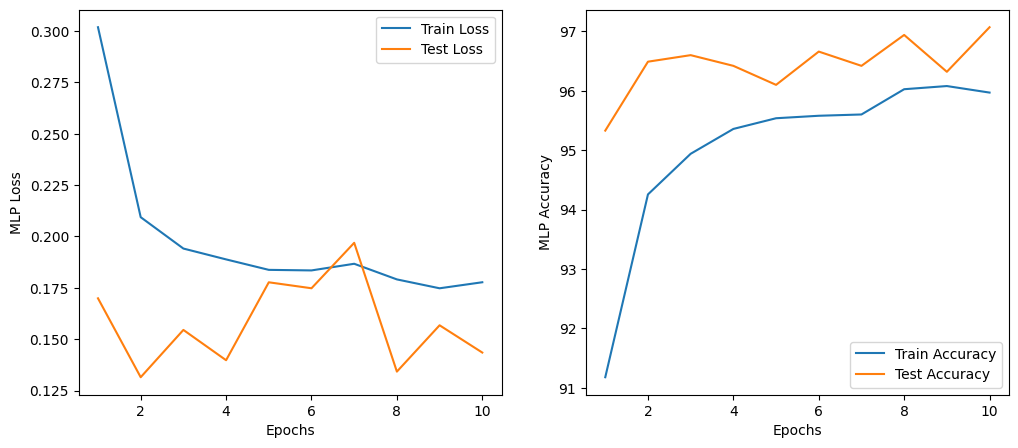

In [18]:
main(10, "MLP", train_mlp, test_mlp)

### 2.5: Infer One Image

In [ ]:
def infer_one(model, image, device="cpu"):
    model.eval()
    model.to(device)
    with torch.no_grad():
        x = image.to(device)
       
        if x.dim() == 3: 
            x = x.unsqueeze(0)
        elif x.dim() == 2:
            x = x.unsqueeze(0).unsqueeze(0)

        logits = model(x)
        pred = logits.argmax(dim=1).item()
    return pred

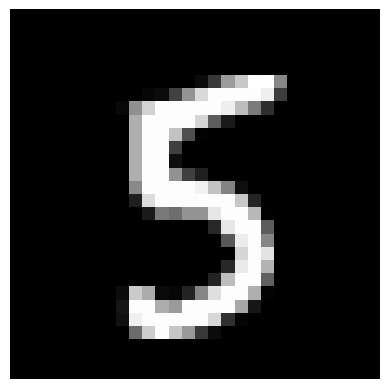

In [25]:
images, labels = next(iter(train_loader))
img_tensor = images[0]

img_data = img_tensor.squeeze().numpy()
cmap_val = "gray" 

plt.imshow(img_data, cmap=cmap_val)
plt.axis("off")
plt.show()


In [26]:
infer_one(mlp_model, img_tensor)

5